# Getting a seasonal decomposition using pandas and statsmodels

In [1]:
# getting some warnings from matplotlib, so turning those warnings off
import warnings
warnings.filterwarnings('ignore')

# importing libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# reading csv to dataframe
filename = './data/airline.csv'
df = pd.read_csv(filename)

In [3]:
# cleaning the columns, setting year month as index
df['YEAR_'] = df['YEAR_'].astype(int)
df['MONTH_'] = df['MONTH_'].astype(int)
df['passengers'] = df['passengers'].astype(int)
df.rename(columns={'YEAR_':'year', 'MONTH_':'month'}, inplace=True)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(Day=1))
df.drop(columns=['DATE_', 'year', 'month'], inplace=True)
df.set_index('date', inplace=True)
df.index.names = ['year_month']

In [4]:
# applying power 1/4 to passengers, should in this case result in a 
# time series to which an additive model can be applied
df['fpass'] = df['passengers'] ** 0.25

In [5]:
df.head(3)

,passengers,fpass
year_month,,
1974-01-01,2568027,40.031
1974-02-01,2223459,38.615
1974-03-01,2776614,40.821


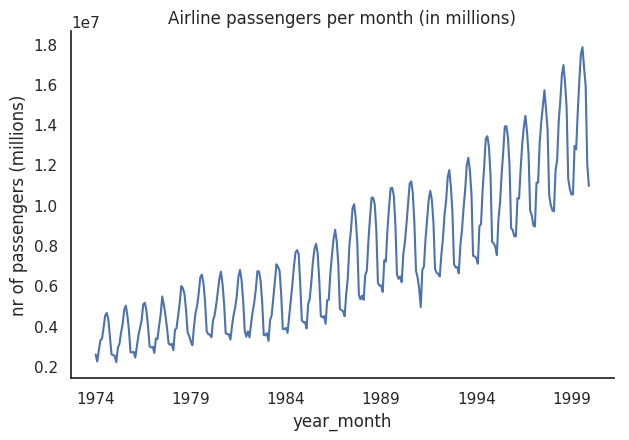

In [6]:
# The graph from passengers does not look like an additive model can be applied here, since the 
# seasonal factors are getting larger over time: a multiplied model?
ax = df['passengers'].plot(title='Airline passengers per month (in millions)')
ax.set(ylabel='nr of passengers (millions)')
sns.despine();

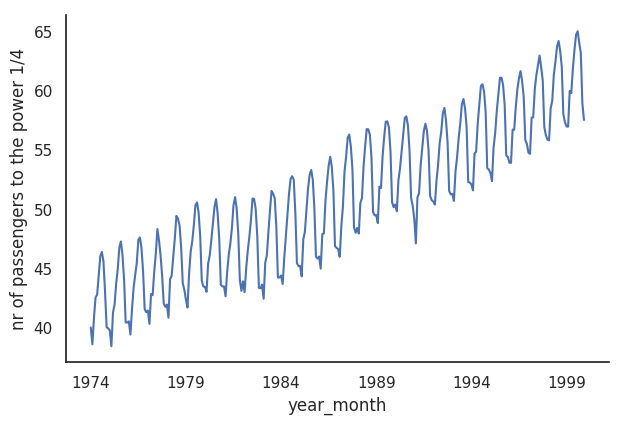

In [7]:
# power 1/4 was applied to passengers, now it looks like an additive model can be applied
# seasonal factors seem regular and so does the irregular component
ax = df['fpass'].plot()
ax.set(ylabel='nr of passengers to the power 1/4')
sns.despine();

In [8]:
# apply statsmodel function seasonal_decompose, which calculates seasonal factors
# and you plot all components: trend, seasonal factors and irregularities
decomp = seasonal_decompose(df['fpass'], model='additive', freq=12)

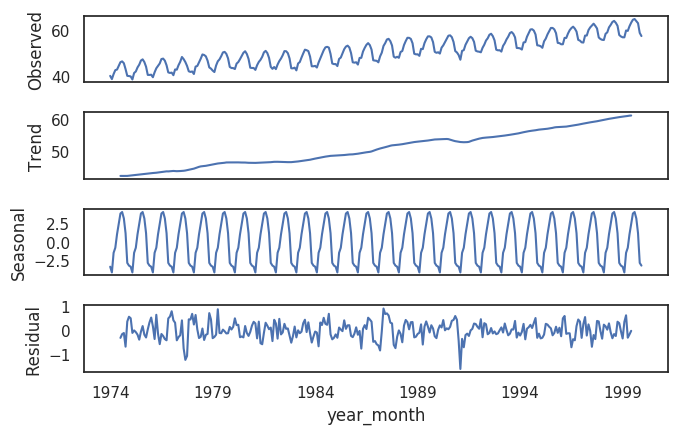

In [9]:
# you can get a quick overview of the decomposition with .plot()
decomp.plot();

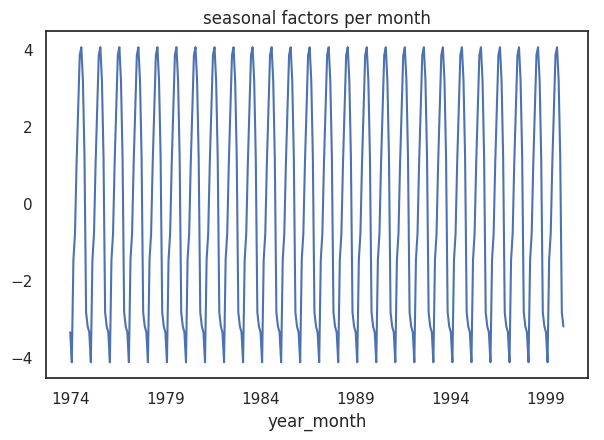

In [10]:
# decomposition contains seasonal factors
decomp.seasonal.plot(title='seasonal factors per month');

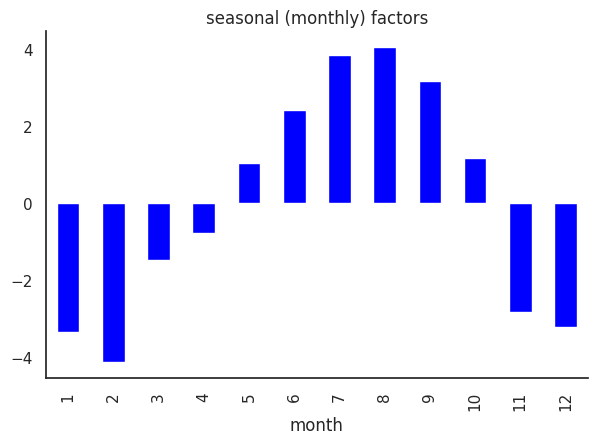

In [11]:
# showing the 12 seasonal factors (which are repeated every year)
ax = decomp.seasonal[0:12].plot(kind='bar', color='blue')
ax.set(title='seasonal (monthly) factors', xlabel='month')
plt.xticks(ticks=range(0,12), labels=range(1,13))
sns.despine();

In [12]:
# add the seasonal factors to dataframe and calculate the seasonal adjusted series
df['seasonal_factor'] = decomp.seasonal
df['seasonal_adjusted'] = df['fpass'] - df['seasonal_factor']
df.head(3)

,passengers,fpass,seasonal_factor,seasonal_adjusted
year_month,,,,
1974-01-01,2568027,40.031,-3.349,43.380
1974-02-01,2223459,38.615,-4.130,42.745
1974-03-01,2776614,40.821,-1.467,42.287


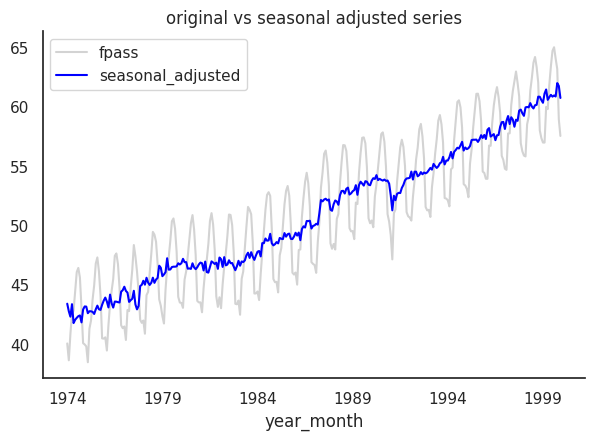

In [13]:
# visualizing original data vs the seasonally adjusted series
df[['fpass', 'seasonal_adjusted']].plot(
    color=['lightgrey', 'blue'],
    title='original vs seasonal adjusted series'
)
sns.despine();

# Calculating Weighted Moving Average

In [14]:
# as an aside: statsmodels uses a weighted moving average to calculate the seasonal factors.
# if you want to calculate this moving average yourself you can use the following:
weights = [.5, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., .5]
sum_weights = sum(weights)
df['weighted_ma'] = (df['fpass']
    .rolling(window=13, center=True)
    .apply(lambda x: np.sum(x*weights) / sum_weights)
)
df.head(10)

,passengers,fpass,seasonal_factor,seasonal_adjusted,weighted_ma
year_month,,,,,
1974-01-01,2568027,40.031,-3.349,43.380,nan
1974-02-01,2223459,38.615,-4.130,42.745,nan
1974-03-01,2776614,40.821,-1.467,42.287,nan
1974-04-01,3280998,42.560,-0.781,43.341,nan
1974-05-01,3352545,42.790,1.041,41.749,nan
1974-06-01,3902043,44.445,2.417,42.028,nan
1974-07-01,4494879,46.045,3.855,42.190,42.514
1974-08-01,4632681,46.394,4.061,42.333,42.497
1974-09-01,4318593,45.586,3.195,42.392,42.509


In [15]:
# the rest in the computer book is just calculating a trend based 
# on a simple moving average of the seasonal adjusted series (so without seasonal factors)
# this technique can be found in the previous notebook (2_Simple_Moving_Averages)